## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')
nx=9
ny=6

In [2]:
def show(img_list, cols=1):
    fig = plt.figure(figsize=(20,5))
    length = len(img_list)
    row = length // cols
    for index in range(1, length-1):
        fig.add_subplot(row, cols, index)
        plt.imshow(img_list[index-1], cmap='gray')
    plt.show()

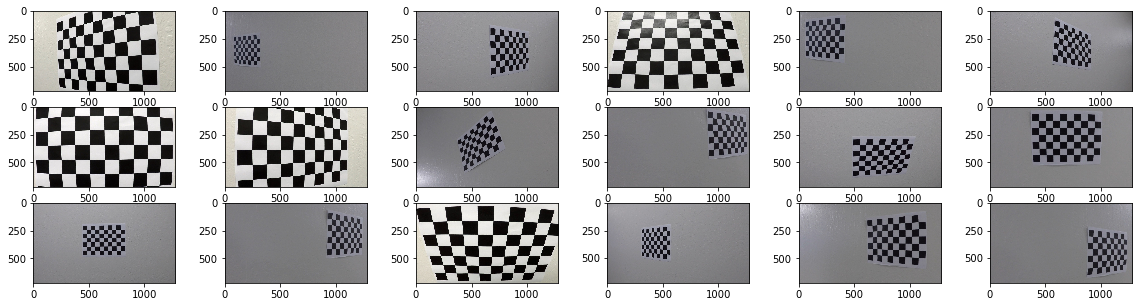

In [3]:
img_list=[plt.imread(image) for image in images]
show(img_list, 6)

### Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

In [4]:
# image=plt.imread(images[1])
objp = np.zeros((9*6, 3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
def cal_dis(img_list):
    objpoints=[]
    imgpoints=[]
    result = []
    for index in range(1, len(img_list)):
        gray = cv2.cvtColor(img_list[index], cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray,(nx, ny), None)
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            img = cv2.drawChessboardCorners(img_list[index], (nx, ny), corners, ret)

            result.append(img)
    return result, objpoints, imgpoints

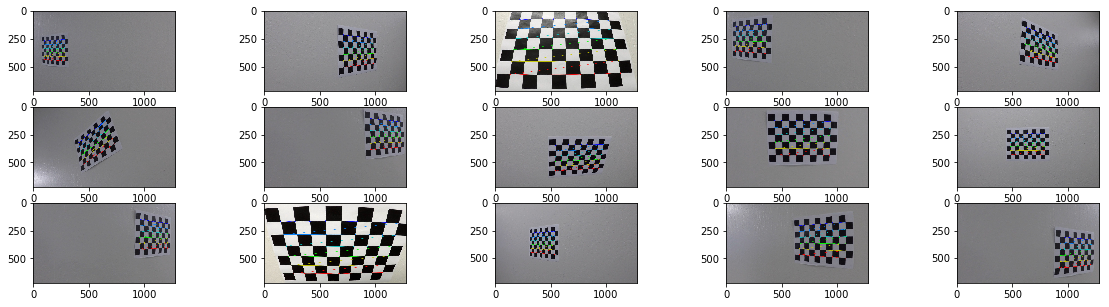

In [5]:
chess_list, objpoints ,imgpoints  = cal_dis(img_list)
show(chess_list, 5)

### Apply a distortion correction to raw images.

In [6]:
def cal_undistort(img_list, objpoints, imgpoints):
    des_result = []
    for index in range(1, len(img_list)):
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_list[index].shape[1::-1], None, None)
        des = cv2.undistort(img_list[index], mtx, dist, None, mtx)
        
        des_result.append(des)


    return des_result, mtx, dist

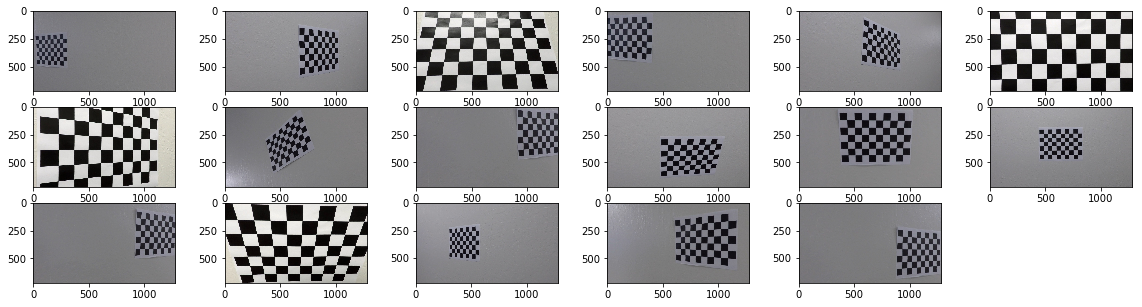

In [7]:
# objpoints, imgpoints = get_calibrate(img_list)
img_list=[plt.imread(image) for image in images]
undistorted_list, mtx, dist = cal_undistort(img_list, objpoints, imgpoints)
show(undistorted_list, 6)

### perspective transform

In [8]:
def corners_unwarp(img_list, nx, ny, mtx, dist):
    warped_list=[]
    for i in range(1, len(img_list)):
        gray = cv2.cvtColor(img_list[i], cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        if ret == True:
            offset = 100
            img_size = (gray.shape[1],gray.shape[0])
            src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
            
            dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        
            M = cv2.getPerspectiveTransform(src, dst)
    
            warped = cv2.warpPerspective(img_list[i], M, img_size)
            warped_list.append(warped)
            
    return warped_list, M
top_down_list, perspective_M = corners_unwarp(undistorted_list, nx, ny, mtx, dist)

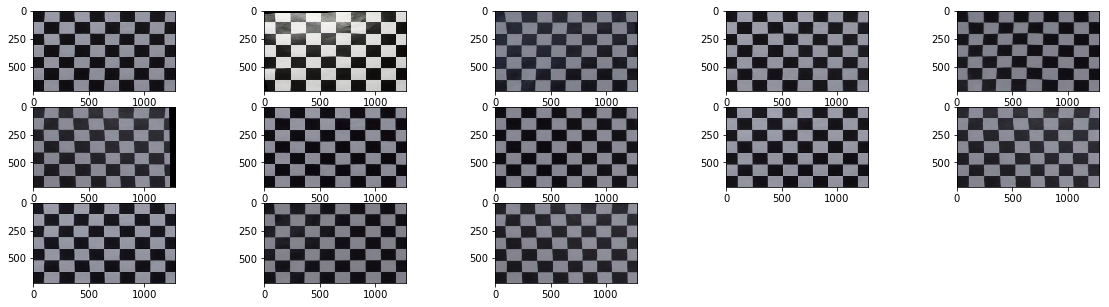

In [9]:
show(top_down_list, 5)

### Use color transforms, gradients, etc., to create a thresholded binary image

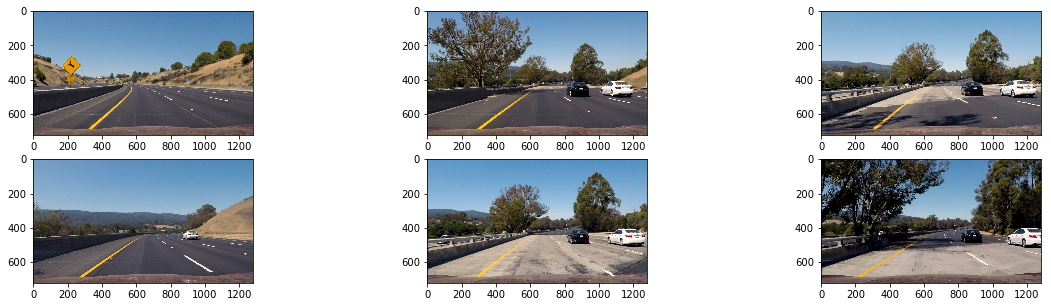

In [10]:
def show(img_list, cols=1):
    fig = plt.figure(figsize=(20,5))
    length = len(img_list)
    row = length // cols
    for index in range(length):
        fig.add_subplot(row, cols, index+1)
        plt.imshow(img_list[index], cmap='gray')
    plt.show()
    
test_images = glob.glob('../test_images/test*.jpg')
test_list = [plt.imread(pa) for pa in test_images]
show(test_list, 3)

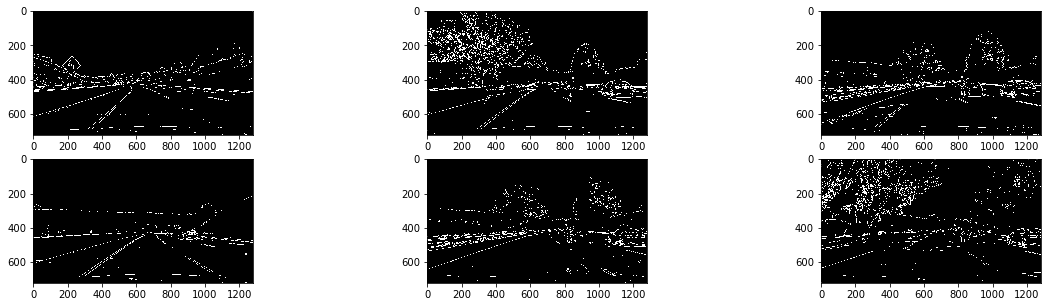

In [11]:
def abs_sobel_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = np.abs(cv2.Sobel(gray, cv2.CV_64F, 0,1, ksize=sobel_kernel))
    
    abs_sobelx = np.sqrt(np.power(sobelx, 2))
    abs_sobely = np.sqrt(np.power(sobely, 2))
    abs_sobelxy = np.sqrt(np.power(sobelx,2) + np.power(sobely, 2))
    
    scale_sobel = np.uint8(255* abs_sobelxy /np.max(abs_sobelxy))
    binary_output = np.zeros_like(scale_sobel)
    mask = (scale_sobel > mag_thresh[0]) & (scale_sobel <= mag_thresh[1])
    binary_output[mask]=1
    return binary_output

show_list_sobel=[]
for img in test_list:
    show_list_sobel.append(abs_sobel_thresh(img, sobel_kernel=3, mag_thresh=(50, 200)))
show(show_list_sobel,3)

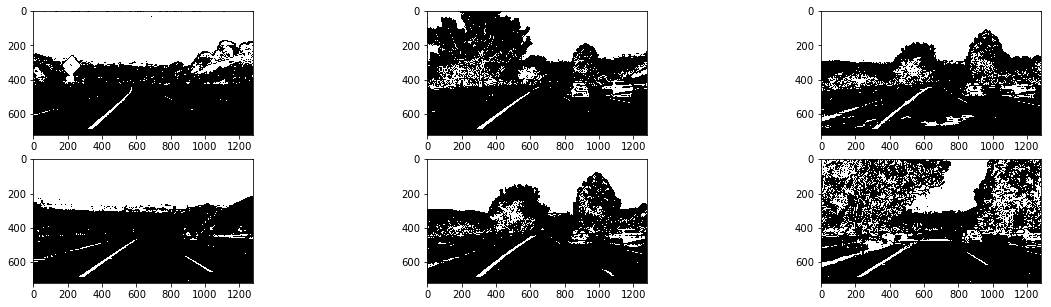

In [12]:
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    sue = hls[:,:,2]
    binary_output = np.zeros_like(sue)
    mask = (sue> thresh[0])&(sue <= thresh[1])
    binary_output[mask]=1
    return binary_output
show_list_hls=[]
for img in test_list:
    show_list_hls.append(hls_select(img, thresh=(90, 255)))
show(show_list_hls, 3)

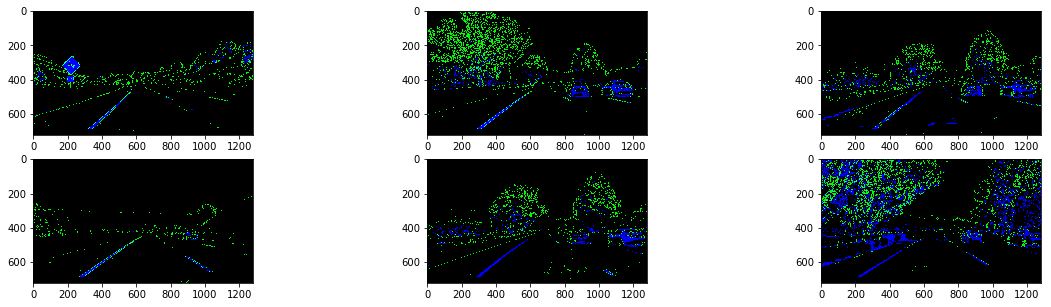

In [13]:
def color_and_gradient(image, s_thresh=(150, 255), sx_thresh=(30, 100)):
    img = np.copy(image)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    abs_sobelx = np.absolute(cv2.Sobel(l_channel, cv2.CV_64F, 1, 0))
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    return color_binary
combined_list=[]
for image in test_list:
    combined_list.append(color_and_gradient(image))
show(combined_list, 3)

In [14]:
def camera_calibration(images, nxy=(9, 6)):
    objpoints, imgpoints= [],[]
    objp = np.zeros((nxy[0]* nxy[1], 3), np.float32)
    objp[:,:2] = np.mgrid[:nxy[0], :nxy[1]].T.reshape((-1, 2))
    for img in images:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(img, nxy)
        if ret:
            objpoints.append(objp)
            imgpoints.append(corners)
    ret, cameraMatrix, distCoeff, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_list[1].shape[1::-1], None, None)
    return cameraMatrix, distCoeff
def undistort(image, mtx, dist):
    return cv2.undistort(image, mtx, dist)

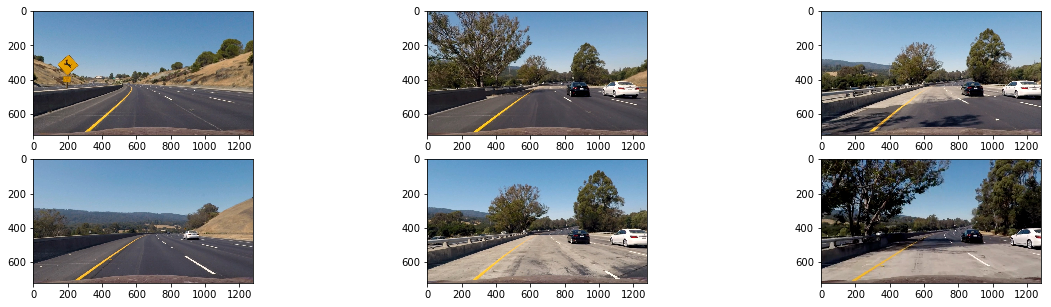

In [15]:
matrix, dist = camera_calibration(img_list)
test_undistort=[]

for image in test_list:
    test_undistort.append(undistort(image, matrix, dist))
show(test_undistort, 3)

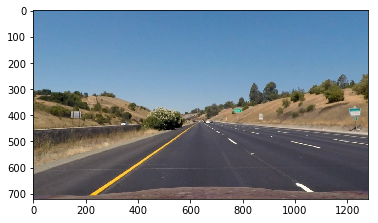

In [16]:
straight_line='../test_images/straight_lines1.jpg'
straight_line = undistort(plt.imread(straight_line), matrix, dist)
plt.imshow(straight_line)

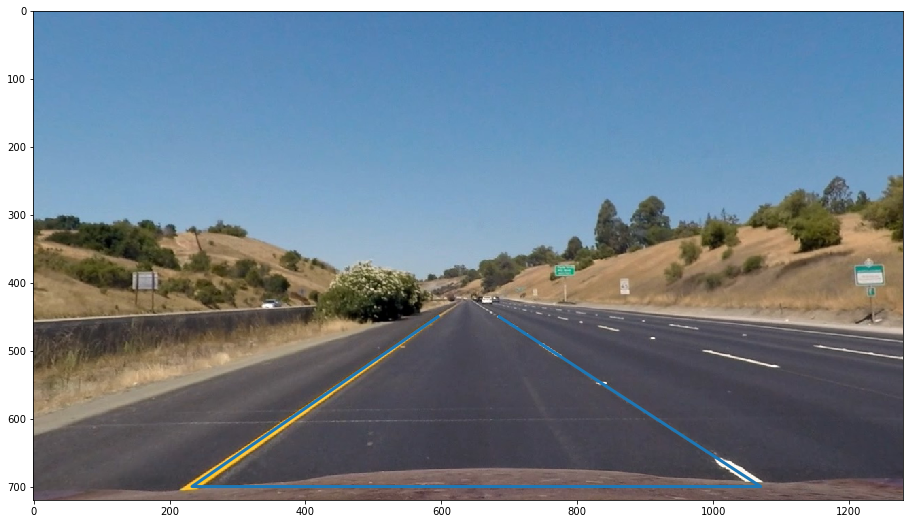

In [17]:
# firstline = 430
# secondline = 700
# x1,x2,x3,x4 = 620, 233, 1070, 655
firstline = 450
secondline = 700
x1,x2,x3,x4 = 595, 233, 1070, 685
first_point = (x1, firstline)
second_point = (x2, secondline)
third_point = (x3, secondline)
fourth_point = (x4, firstline)
src= np.float32([first_point, second_point, third_point, fourth_point])
dst = np.float32([(x2,0),(x2, 720), (x3, 720), (x3, 0)])
fig = plt.figure(figsize=(16,9))
plt.imshow(straight_line)
plt.plot(src.T[0], src.T[1], linewidth=3)

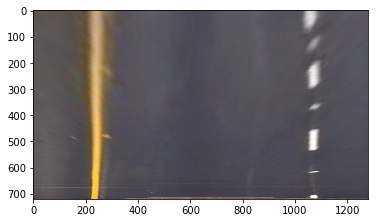

In [18]:
M = cv2.getPerspectiveTransform(src, dst)
M_ = cv2.getPerspectiveTransform(dst, src)
plt.imshow(cv2.warpPerspective(straight_line, M, straight_line.shape[1::-1]))

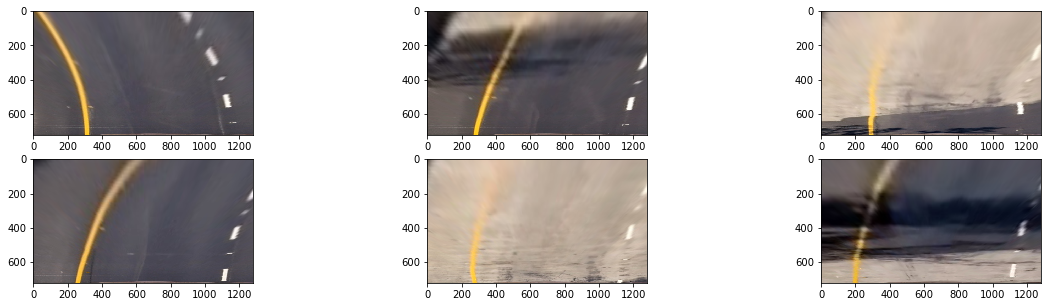

In [19]:
perspectived_list = []
for img in test_undistort:#test_list
    perspectived_list.append(cv2.warpPerspective(img, M, img.shape[1::-1]))
show(perspectived_list, 3)

### Detect lane pixels and fit to find the lane boundary.

In [20]:
def find_lane_pixels(binary_warped):
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:],axis=0)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    midpoint = np.int(histogram.shape[0]//2)#1028/2
    leftx_base = np.argmax(histogram[:midpoint])

    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    nwindows = 20
    margin = 100
    minpix = 50
    
    window_height = np.int(binary_warped.shape[0]//nwindows)
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    left_lane_inds, right_lane_inds =[], []
    for window in range(nwindows):
        win_y_low = binary_warped.shape[0]- (window + 1) * window_height
        win_y_high = binary_warped.shape[0]- window * window_height
        #### error
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        cv2.rectangle(out_img, (win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2)
        cv2.rectangle(out_img, (win_xright_low, win_y_low),
        (win_xright_high, win_y_high),(0, 255,0),2)
        
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high)&
        (nonzerox >= win_xleft_low) & (nonzerox< win_xleft_high)).nonzero()[0]
        
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        pass    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    return leftx, lefty, rightx, righty, out_img

def fit_polynomial(binary_warped):
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    return out_img, left_fitx, right_fitx, ploty, left_fit, right_fit

def show_2(img_list, left_fitx, right_fitx, ploty, cols=1):
    fig = plt.figure(figsize=(20,5))
    length = len(img_list)
    row = length // cols
    for index in range(length):
        fig.add_subplot(row, cols, index+1)
        plt.plot(left_fitx[index], ploty[index], color='yellow')
        plt.plot(right_fitx[index], ploty[index], color='yellow')
        plt.imshow(img_list[index], cmap='gray')
    plt.show()

In [21]:
binary_warped_list=[]
for img in perspectived_list:
    result = color_and_gradient(img, s_thresh=(100, 255), sx_thresh=(200, 255))
    result = cv2.cvtColor(result, cv2.COLOR_RGB2HLS)[:,:,2]
    binary_warped_list.append(result)

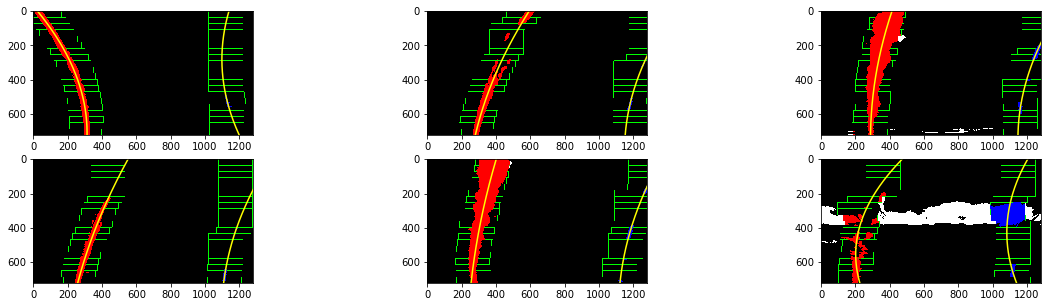

In [22]:
final_out_list, left_fit_list, right_fit_list = [],[],[]
left_fitx_list, right_fitx_list, ploty_list=[],[],[]
for img in binary_warped_list:
    result = fit_polynomial(img)
    final_out_list.append(result[0])
    left_fitx_list.append(result[1])
    right_fitx_list.append(result[2])
    ploty_list.append(result[3])
    left_fit_list.append(result[4])
    right_fit_list.append(result[5])
show_2(final_out_list, left_fitx_list, right_fitx_list, ploty_list, 3)

In [23]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):

    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])

    left_fitx = left_fit[0]*ploty**2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped, left_fit, right_fit):
    margin = 100

    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    left_lane_inds = ((nonzerox > -margin+ left_fit[0]*nonzeroy**2+left_fit[1]*nonzeroy+left_fit[2])&
    (nonzerox < +margin + left_fit[0]*nonzeroy**2 + left_fit[1]*nonzeroy + left_fit[2])).nonzero()[0]
    
    right_lane_inds = ((nonzerox > -margin + right_fit[0]*nonzeroy**2 + right_fit[1]*nonzeroy + right_fit[2])&
    (nonzerox <  margin + right_fit[0]*nonzeroy**2 + right_fit[1]*nonzeroy + right_fit[2])).nonzero()[0]
    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')
    
    return result
result = search_around_poly(binary_warped_list[0], left_fit_list[0], right_fit_list[0])

In [24]:
final_=[]
for index in range(len(binary_warped_list)):
    final_.append(search_around_poly(binary_warped_list[index], left_fit_list[index], right_fit_list[index]))

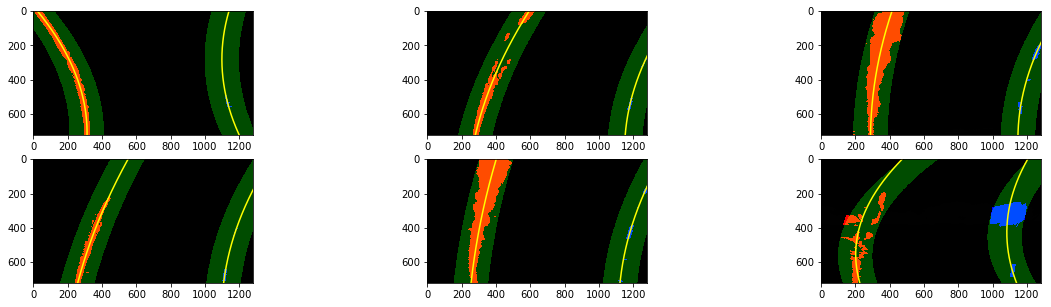

In [25]:
show_2(final_, left_fitx_list, right_fitx_list, ploty_list, 3)